# Continued from Milestone 1
## Step 2: Let's Dive into the dataset! (Initial Observations, Data cleaning, and general prep work)
### Initial observation through profile reports
The two `.html` files in the `analysis` folder are profile reports generated through the `pandas_profiling` module, which allows us to see a detailed description of the data and some preliminary statistics and metadata about the data as well. This will help us identify what types of values there are, and what values we need to clean up!

The Profiling Report file for each dataframe was created using the following code:

`pr = pprof.ProfileReport(ratings_df)
pr.to_file(output_file='ratings_profiling_report.html')
pr = pprof.ProfileReport(anime_df)
pr.to_file(output_file='anime_profiling_report.html')`

**NOTE:** *This is not included in the notebook since the files are quite large (around 100MB), and running this profiling locally each time would take too much time.*

### Data Cleanup
We already have python methods that will load and clean/process the data for us in the `scripts` folder, so let's use that to help us prep the data! 

Sadly, I couldn't figure out how to do the relative imports like everyone else on Piazza so here's me trying and failing:

![fail](../images/ImportError.png)

I've left the folders and everything intact so it proves I tried. For this analysis instead I'll just run these methods locally in the notebook...

In [62]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.style as style
import seaborn as sns
import csv
import warnings
warnings.filterwarnings("ignore")

#Seaborn Settings
sns.set_theme(style = 'ticks', font_scale = 2)

#Process the anime.csv file
def load_and_process_anime(path):
    #Deal with unnecessary data and missing values
    df1 = pd.read_csv(path)
    df1 = df1.drop(columns='members').loc[~((df1['episodes'] == 'Unknown') | (df1['episodes'] == 'NaN') | (df1['rating'].isna()))].dropna(axis=0)
    #Process some data, and remove any rows with the 'Hentai' to keep things family-friendly
    df1 = df1.assign(genre = lambda x: x.genre.str.split(",")).sort_values("anime_id").loc[~(df1['genre'].isin(['Hentai']))].reset_index(drop=True)
    df1['episodes'] = pd.to_numeric(df1['episodes'])
    return df1

#process the rating.csv file
def load_and_process_ratings(path,whitelist):
    #Deal with unnecessary data and missing values
    df1 = pd.read_csv(path)
    df1 = df1.loc[~((df1['rating'] == -1 ) | (df1['rating'].isna()))].dropna(axis=0) #Ditch the rows with a rating of -1 which means the user watched it but didn't rate it
    
    #Process some data, and remove any rows with the 'Hentai' to keep things family-friendly
    df1 = df1.loc[(df1['anime_id'].isin(whitelist))].reset_index(drop=True)
    return df1

Okay! Now we can finally load and use the data!

In [2]:
anime_df = load_and_process_anime('../data/raw/anime.csv')
anime_df

,anime_id,name,genre,type,episodes,rating
0,1,Cowboy Bebop,"[Action, Adventure, Comedy, Drama, Sci-Fi,...",TV,26,8.82
1,5,Cowboy Bebop: Tengoku no Tobira,"[Action, Drama, Mystery, Sci-Fi, Space]",Movie,1,8.40
2,6,Trigun,"[Action, Comedy, Sci-Fi]",TV,26,8.32
3,7,Witch Hunter Robin,"[Action, Drama, Magic, Mystery, Police, S...",TV,26,7.36
4,8,Beet the Vandel Buster,"[Adventure, Fantasy, Shounen, Supernatural]",TV,52,7.06
...,...,...,...,...,...,...
11040,34476,Platonic Chain: Ansatsu Jikkouchuu,"[Sci-Fi, Slice of Life]",Special,1,1.67
11041,34490,Sushi Azarashi,[Comedy],TV,30,3.00
11042,34503,Kochinpa! Dainiki,[Comedy],TV,24,3.40
11043,34514,Pokemon Generations,"[Action, Adventure, Fantasy, Game, Kids]",ONA,18,7.21


In [3]:
id_set = set(anime_df['anime_id'].tolist()) #Create a list of all the anime that are still in the anime dataset for filtering
ratings_df = load_and_process_ratings('../data/raw/rating.csv', id_set)
ratings_df

,user_id,anime_id,rating
0,1,8074,10
1,1,11617,10
2,1,11757,10
3,1,15451,10
4,2,11771,10
...,...,...,...
6294160,73515,16512,7
6294161,73515,17187,9
6294162,73515,22145,10
6294163,73516,790,9


## Step 3: Quick and Dirty Exploratory Data Analysis

Okay, now our data has been prepped, lets do a quick and simple EDA to gauge the relationships and show us things on levels that we couldn't see in the profile report.

First up, What does our dataset look like, in terms of variables, size, shape and some preliminary stats.

In [4]:
print('Anime Database: ' + str(anime_df.shape))
print('Ratings Database: ' + str(ratings_df.shape))

Anime Database: (11045, 6)
Ratings Database: (6294165, 3)


In [5]:
anime_df.dtypes

anime_id      int64
name         object
genre        object
type         object
episodes      int64
rating      float64
dtype: object

In [6]:
ratings_df.dtypes

user_id     int64
anime_id    int64
rating      int64
dtype: object


After cleanup, there is info on around 11,000 anime, and 6.2 million user ratings for those anime (WOW that's a lot... no wonder this file is like 100MB).

How is the spread of data then?

In [7]:
anime_df.describe().T

,count,mean,std,min,25%,50%,75%,max
anime_id,11045.0,13648.355455,11210.381529,1.00,3268.00,10079.0,23711.00,34519.0
episodes,11045.0,13.229153,48.655875,1.00,1.00,2.0,13.00,1818.0
rating,11045.0,6.504679,1.036618,1.67,5.91,6.6,7.23,10.0


In [8]:
ratings_df.describe().apply(lambda s: s.apply(lambda x: format(x, 'f'))).T #to supress scientific notations

,count,mean,std,min,25%,50%,75%,max
user_id,6294165.000000,36738.980104,21020.113196,1.000000,18973.000000,36800.000000,54876.000000,73516.000000
anime_id,6294165.000000,8910.444038,8891.315494,1.000000,1222.000000,6213.000000,14131.000000,34475.000000
rating,6294165.000000,7.816138,1.567153,1.000000,7.000000,8.000000,9.000000,10.000000


Okay, there doesn't seem to be any issues here, and it seems to tell us things we already knew. So let's continue.

Next up, some visualizations to help with our understanding. 

### Anime Database:

Let's try a general visualization to see the episode counts by type of anime

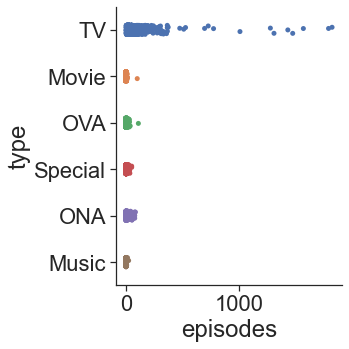

In [9]:
sns.catplot(x='episodes', y='type',data=anime_df)
sns.despine()

Okay, so we now know that there are 6 types of anime but the most common is TV.

Let's do another one to find out about these categories!

<AxesSubplot:xlabel='type', ylabel='count'>

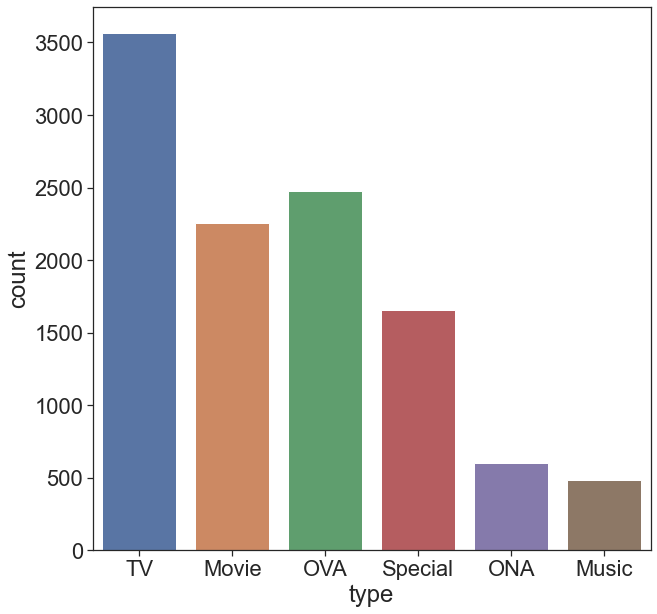

In [16]:
plt.figure(figsize=(10,10))
sns.countplot(x='type',data=anime_df)

Whoa! There's like 3500+ TV shows alone! That's surreal to think about...

**Fun Fact**: the Anime with the highest number of episodes according to this dataset is "Oyako Club", with 1818 episodes at the time of data retrieval! 

Next, let's see what the relationship between episode numbers and rating is.

<AxesSubplot:xlabel='episodes', ylabel='rating'>

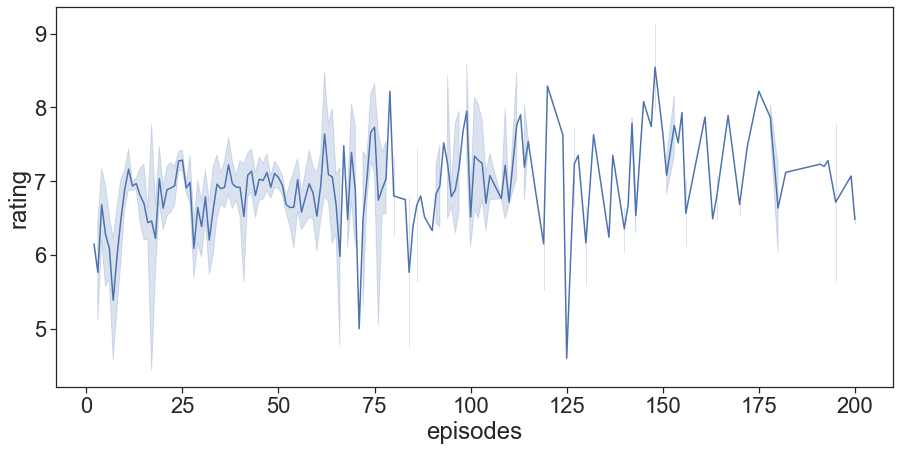

In [41]:
plt.figure(figsize=(15,7))
sns.lineplot(x='episodes', y='rating',data=anime_df.loc[((anime_df['episodes'] <= 200) & (anime_df['type'] == 'TV'))])

 This plot was limited to just TV series, since adding movies and specials might skew the plotting a little since their episode counts are usually very low, but let's try it out for Everything other than Movies or TV shows then!

<AxesSubplot:xlabel='episodes', ylabel='rating'>

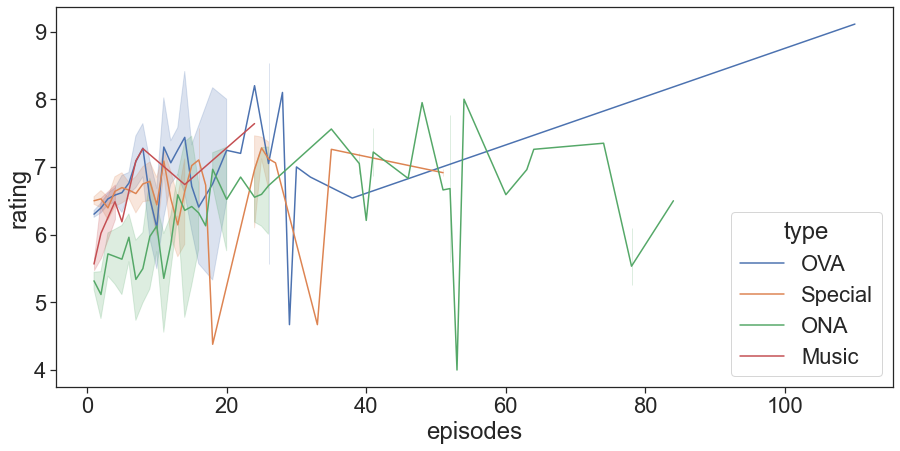

In [46]:
plt.figure(figsize=(15,7))
sns.lineplot(x='episodes', y='rating', hue= 'type',data=anime_df.loc[~((anime_df['type'] == 'Movie') | (anime_df['type'] == 'TV'))])

**Thoughts**: Well, there isn't anything too interesting other than the fact that the rating generally is higher for anime as the episode count goes up, but it isn't guaranteed.

### Ratings Database:

Okay here's where things get interesting (and slightly more complex). We know the average rating for each anime, but how about how users rated individual anime? Let's take a look at some basic stats.

Let's see the frequencies of each rating since they are all on a scale of 1 to 10:

<AxesSubplot:xlabel='rating', ylabel='count'>

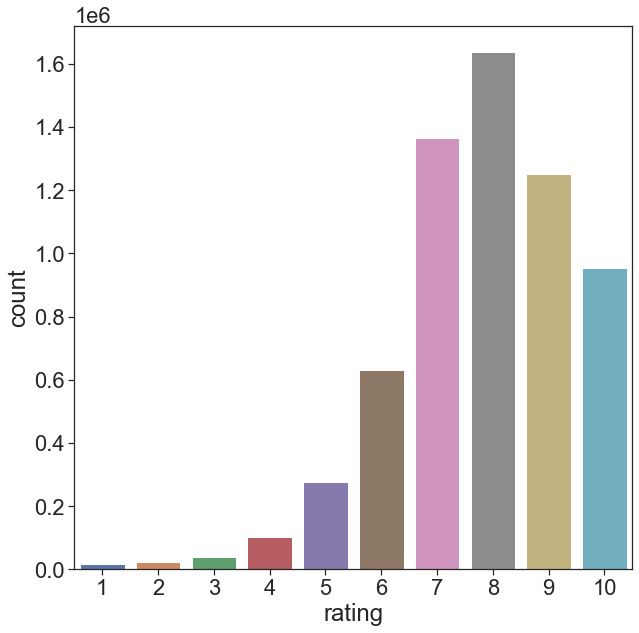

In [49]:
plt.figure(figsize=(10,10))
sns.countplot(x='rating',data=ratings_df)

Well, The highest occurring rating seems to be 8, so is the majority of anime an 8/10?

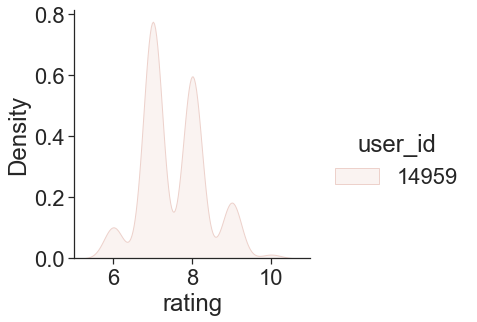

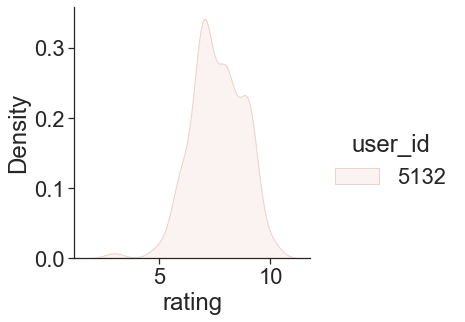

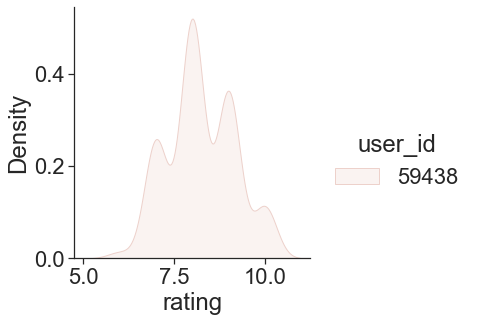

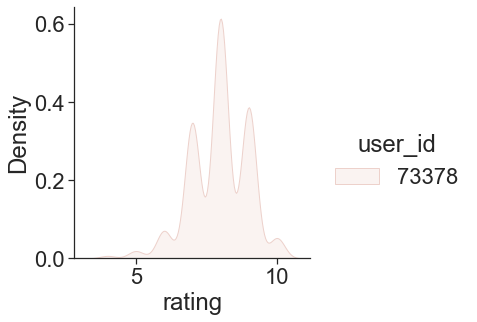

In [82]:
for x in range(1, 5):
    sns.displot(x='rating',hue="user_id",kind="kde",fill=True,data=ratings_df.loc[ratings_df['user_id'] == ratings_df['user_id'].sample().tolist()[0]])